# COMP541 Visualization Lab
* In this Lab you will implement some methods and experiment with several visualization techniques.
* Please read all the instructions and comments carefully.
* **IMPORTANT: NEXT STEP MAY TAKE A LITTLE BIT LONGER. PLEASE WAIT UNTILL ALL YOUR PACKAGES are installed.**

In [1]:
# You may comment out this cell after installing all the necessary packages

In [2]:
using Pkg; installed = Pkg.installed()
for p in ("Knet", "IJulia", "Images", "ImageMagick", "Plots", "Plotly", "PlotlyJS", "ORCA", "MAT")
    haskey(installed,p) || Pkg.add(p)
end
pkg"add https://github.com/ilkerkesen/Sloth.jl"

┌ Warning: Pkg.installed() is deprecated
└ @ Pkg D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.5\Pkg\src\Pkg.jl:554
   Updating git-repo `https://github.com/ilkerkesen/Sloth.jl`


   Updating registry at `C:\Users\volkan\.julia\registries\General`
  Resolving package versions...
No Changes to `C:\Users\volkan\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\volkan\.julia\environments\v1.5\Manifest.toml`


In [3]:
# PLEASE WAIT TO FINISH PACKAGE INSTALLATION

In [4]:
# A bit of setup as usual
using Knet, Sloth, IJulia, Images, Plots, Statistics, Test
F = eltype(Knet.atype())

const IMAGES = [
    ("https://github.com/BVLC/caffe/raw/master/examples/images/cat.jpg", "cat.jpg", 284),
    ("http://farm1.static.flickr.com/64/168461914_afe4852372.jpg", "elephant.jpg",387),
    ("http://www.treetopics.com/quercus_macrocarpa/buroak_2919.jpg","buroak_2919.jpg",704),
    ("https://i.ibb.co/J2jdYjH/15-1.jpg","dog.jpg",187)
];

┌ Warning: Error requiring `HDF5` from `Plots`
│   exception = (LoadError("C:\\Users\\volkan\\.julia\\packages\\Plots\\IjNHT\\src\\backends\\hdf5.jl", 162, UndefVarError(:Group)), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00000000668443c1, Ptr{Nothing} @0x00000000668ca09d, Ptr{Nothing} @0x00000000668ca5e2, Ptr{Nothing} @0x00000000668ca2c1, Ptr{Nothing} @0x00000000668cadd0, Ptr{Nothing} @0x00000000668cb7a5, Base.InterpreterIP in top-level CodeInfo for Plots._hdf5_implementation at statement 4, Ptr{Nothing} @0x00000000668e8e5d, Ptr{Nothing} @0x00000000668e9b39, Ptr{Nothing} @0x00000000668e922a, Ptr{Nothing} @0x00000000668e9499, Ptr{Nothing} @0x00000000668bd5fb, Ptr{Nothing} @0x00000000668ea77d, Ptr{Nothing} @0x00000000098f8b31, Ptr{Nothing} @0x0000000033d4a66d, Ptr{Nothing} @0x00000000668ca5fc, Ptr{Nothing} @0x00000000668ca2c1, Ptr{Nothing} @0x00000000668cadd0, Ptr{Nothing} @0x00000000668cb7a5, Base.InterpreterIP in top-level CodeInfo for Plots at statement 10, Ptr{Nothing}

In [5]:
# Construct our model based on VGG16, returns class scores
model = Sloth.vgg16(pretrained=true)
average_image, classes = Sloth._get_imagenet_metadata();

## Implement Image Processing Procedures

In [6]:
"""
    download_image(url, path)

Download image from `url`, then save it to `path`.
"""
function download_image(url, path)
    if !isfile(path)
        @info "Downloading $url to $path"
        download(url, path)
    end
end;

"""
    resize_crop_image(image, len::Int=224)

Resize, and then crop `image`. Output image has dimensions `len`x`len`.
"""
function resize_crop_image(image, len=224)
    a0 = image
    new_size = ntuple(i->div(size(a0,i)*len,minimum(size(a0))),2)
    a1 = Images.imresize(a0, new_size)
    i1 = div(size(a1,1)-len,2)
    j1 = div(size(a1,2)-len,2)
    b1 = a1[i1+1:i1+len,j1+1:j1+len]
    RGB{Float64}.(b1)
end


"""
    vgg_image(cropped, average_image)

Make input image `cropped` valid for `vgg16`.
"""
function vgg_image(cropped, average_image=F(0.0))
    b1 = convert(Array{FixedPointNumbers.Normed{UInt8,8},3}, channelview(cropped))
    c1 = permutedims(b1, (3,2,1))
    d1 = convert(Array{Float32}, c1)
    e1 = reshape(d1[:,:,1:3], (224,224,3,1))
    f1 = (255 * e1 .- average_image)
    g1 = permutedims(f1, [2,1,3,4])
end

"""
    preprocess(image, average_image)

Make raw image `image` valid for `vgg16`.
"""
function preprocess(image, average_image=F(0.0))
    vgg_image(resize_crop_image(image), average_image)
end

preprocess

## Process and then Visuazlize Example Images

,,,

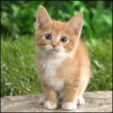
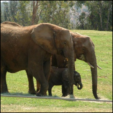
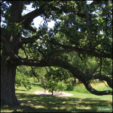
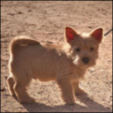

In [7]:
# Download and then process images
for (url, path, class) in IMAGES
    download_image(url, path)
end
paths, labels = map(x->x[2], IMAGES), map(x->x[3], IMAGES)
crops = [resize_crop_image(load(path)) for path in paths]
inputs = [vgg_image(crop, average_image) for crop in crops]

crops

## Occlusion Experiments
You are going to occlude input image from different regions and observe the probability of predicted class of occluded image.

For Occlusion Experiments, you need to:
* Complete `occlude_image` method.
* Pass the generated occluded images through the model and update the results matrix with the probability of the original predicted class you get with the occluded image.

### Finishing up the occlude_image method
It is used to obtain occluded versions of the orjinal image. You are going to modify the input image by moving occlusion box through the image. You will return `occluded_images` array of arrays which stores modified images, each of which has is a `KnetArray{Float32,4}` array. The color of the occlusion box will be the mean color of original image.
Parameters of `occlude_image` method:
* `image` : output of resize_crop_image method. It's type is Array{RGB}.
* `occlusion_size` : `(w,h)` tuple defining the size of occlusion box.
* **Hint**: Double check that you are occluding only a single region at a time in the input image
* **Hint-2**: You may want to use **preprocess** method to convert your occluded image to desired type before pushing it to **occluded_images**.

In [8]:
"""
    occlude_image(image, occlusion_size)

Generate occluded images with size `occlusion_size` for different regions of
input image `image` by moving occlusion box `occbox`.
"""
function occlude_image(image, occlusion_size=(56,56))
    
    w,h = size(image)
    num_rows, num_cols = div(w, occlusion_size[1]), div(h, occlusion_size[2])
    occluded_images = Array{Knet.atype()}(undef, num_rows, num_cols)
    # we use these values in our occlusion box
    meanvals = mean(image)
    occbox  = zeros(RGB{Float64},(occlusion_size)) .+ meanvals
    for (i, c1) in enumerate(1:occlusion_size[1]:w)
        for (j, c2) in enumerate(1:occlusion_size[2]:h)
            
            # Your code here
            img_new = copy(image)
            img_new[c1:c1 + occlusion_size[1]-1, c2:c2 + occlusion_size[2]-1] = occbox
            occluded_images[i,j] = preprocess(img_new)
            
        end
    end
    occluded_images
end
@test sum(abs2.(occlude_image(crops[1])[1,1][1:56,1:56,1])) ≈ 5.71536f7

Test Passed

### Processing occluded_images
Inside the next cell, you will classify each occluded image stored in
`occluded_images` array. The code for classifying the original image and
iterating over the occluded images are given. After each classification, you
will store the probability of target class in the results matrix at the
correct position.

In [9]:
"""
    process_occluded_images(occlusion_image_index::Int=1)

Predict occluded images as labels, and calculate probabilities for labels with
maximum score.
"""
function process_occluded_images(occlusion_image_index=1)
    println("Most confident class and probability of the original image:")
    scores = Array(softmax(model(Knet.atype(inputs[occlusion_image_index]))))
    lindex = LinearIndices(scores)
    prob, cindex = findmax(scores)
    bestlabel = lindex[cindex]
    println("Class $bestlabel with probability $prob\n")
    flush(stdout)

    occluded_images = occlude_image(crops[occlusion_image_index], (56,56))
    result = zeros(size(occluded_images))
    predicted = Array{Int,2}(undef, size(result))

    for i in 1:size(occluded_images, 1)
        for j in 1:size(occluded_images, 2)
            occluded_image = occluded_images[i, j]
            # Your code here
            scores = Array(softmax(model(Knet.atype(occluded_image))))
            lindex = LinearIndices(scores)
            prob, cindex = findmax(scores)
            bestlabel = lindex[cindex]
            result[i,j] =  prob
            predicted[i,j] = bestlabel
        end
    end

    return result, predicted
end

result, predicted = process_occluded_images()
println("Probability matrix of the class under different occlusions:")
flush(stdout)
display(result)

println("Predicted classes:")
flush(stdout)
display(predicted)
flush(stdout)

@test predicted[1] == 286
@test predicted[end] == 282

Most confident class and probability of the original image:
Class 282 with probability 0.27326995

Probability matrix of the class under different occlusions:


4×4 Array{Float64,2}:
 0.355977  0.387736  0.432164  0.461491
 0.332205  0.19766   0.204483  0.345875
 0.375295  0.378962  0.311387  0.330126
 0.3354    0.384649  0.36276   0.351959

Predicted classes:


4×4 Array{Int64,2}:
 286  286  286  286
 286  286  286  286
 286  286  286  286
 282  283  286  282

Test Passed

## Saliency Maps

We will compute saliency maps described in section 3.1 of [1].

A saliency map is a guide to see which parts of the image affects the
prediction of a class. To do that you need to implement `compute_saliency`
which will return the unnormalized class score of the given image.
After implementing forward calculation AutoGrad will calculate gradients with
respect to the image pixels and the provided function will display the
saliency map.

[1] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside
Convolutional Networks: Visualising Image Classification Models and Saliency
Maps", ICLR Workshop 2014.

Saliency Visualisation - for each pixel maximum of absolute gradient in each channel

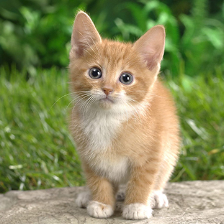

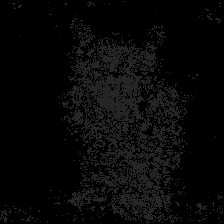

Test Failed at In[164]:24
  Expression: sum(abs2.(saliency_map[33:64, 33:64, 1, :])) ≈ 4.3705796f-7
   Evaluated: 4.3791707f-7 ≈ 4.3705796f-7


LoadError: There was an error during testing

In [164]:
mnistview(x,i)=colorview(Gray,permutedims(x[:,:,1,i],(2,1)))
function visualize_saliency(gimg1)
    g1 = abs.(gimg1);
    g2 = maximum(Array(g1), dims=3)
    g2[g2 .> 1.0f-4] .+= 0.15 ## Enhances visibility
    display(mnistview(g2,1)')
end

"""
    compute_saliency(image, gold_label)

Compute saliency map for the given image `image` and label `gold_label` pair.
"""
function compute_saliency(image, gold_label)
     return model(image)[gold_label]
end

saliency_image_index = 1
img_param = Param(Knet.atype(inputs[saliency_image_index]))
J = @diff compute_saliency(img_param, labels[saliency_image_index])
display(crops[saliency_image_index])
saliency_map = grad(J, img_param)
visualize_saliency(saliency_map)
@test sum(abs2.(saliency_map[33:64,33:64,1,:])) ≈ 4.3705796f-7

## Weight Visualization
We will visualize the weights of VGG16 model's first layer.
To do that, the only thing you need to to is complete `visualize_weights` method.
Since you will be using an unfamiliar implementation, the weights for the
first layer of the model is already extracted from the model.

**Hint**: You need to shift all the weight values between 0 and 1.<br>
**Hint-2**: You may want to look at `RGB` type and `colorview` method defined in `Images` package.<br>
**Hint-3**: To resize the image, you may want to take a look at `imresize` method defined in `Images` package.

In [163]:
"""
    visualize_weights(weights, scale=(16, 16))

Perform weight visualization for the convolutional layer weights, `weights`.
"""
function visualize_weights(weights, scale=(16, 16))
    # 1) Convert your weight to Array{Float32} type
    # 2) Clamp the weight array elements: All of them must be greater than or
    #    equal to zero.
    # 3) If you have N^2 filters in that layer, you will display them in a NxN
    #    grid. You will store each filter in a result array.
    # 4) You will resize each filter by using scale parameter. You may want to
    #    use imresize method.
    result = Any[]

    sqrtsize = Int(floor(sqrt(size(weights,4))))
    for i=1:sqrtsize
        result_col = Any[]
        for j=1:sqrtsize
            # Your code here
            
            w = weights[:,:,:, (i-1)*sqrtsize + j] 
            w = convert(Array{Float32, 3}, w)
            w = clamp.(w, 0, 1.0)
            w = permutedims(w, (3,2,1))
            w = colorview(RGB, w)
            w = imresize(w; ratio = scale)
            push!(result_col,w')

        end
        push!(result, hcat(result_col...))
    end
    vcat(result...)
end

visualize_weights

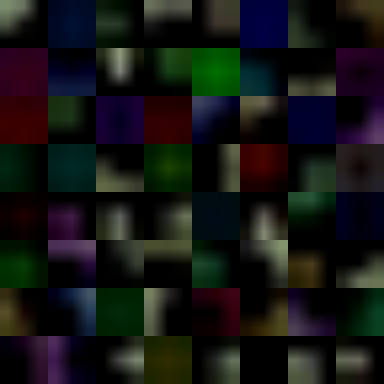

In [161]:
weights = model.features[1].weight.value
results = visualize_weights(weights)
as_array = F.(channelview(results))
@test sum(abs2.(as_array[1,41:80,41:80])) ≈ 8.362223f0
display(results)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*